# Lab: VAE - Image Reconstruction, Generation and Disentanglement in Pytorch

**Student: Lucas Versini**

For any remark or suggestion on this lab, please feel free to contact me at:

- loic.lefolgoc@telecom-paris.fr

### Objective:

We are going to train a Variational Auto-Encoder (VAE), and compare different VAE models in terms of image generation, reconstruction and disentanglement. We will focus on the $\beta$-VAE for this lab. We will work on a synthetic dataset: dSprites https://github.com/google-deepmind/dsprites-dataset.

The lab will be implemented using the Pytorch environment : https://pytorch.org/.
    
### Your task:
You need to add the missing parts in the code (generally marked by `...`) and answer several questions.

# Load packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import copy
import os
import subprocess

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
import sklearn.preprocessing, sklearn.metrics

In [3]:
from tqdm import tqdm

# Load the dataset: dSprites

We are going to train a VAE on a synthetic image dataset : dSprites. To quote the dataset description: dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth independent latent factors. These factors are color, shape, scale, rotation, x and y positions of a sprite.

All possible combinations of these latents are present exactly once, generating N = 737280 total images.

Latent factor values:
*   Color: white
*   Shape: square, ellipse, heart
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: 40 values in [0, 2 pi]
*   Position X: 32 values in [0, 1]
*   Position Y: 32 values in [0, 1]

The shapes are represented as 64x64 binary images.

In [4]:
class DSprites(torch.utils.data.Dataset):
    """DSprites Dataset from [1].

    Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6
    disentangled latent factors. This dataset uses 6 latents, controlling the color,
    shape, scale, rotation and position of a sprite. All possible variations of
    the latents are present. Ordering along dimension 1 is fixed and can be mapped
    back to the exact latent values that generated that image.

    Notes
    -----
    - Link : https://github.com/deepmind/dsprites-dataset/
    - hard coded metadata because issue with python 3 loading of python 2

    Parameters
    ----------
    root : string
        Root directory of dataset.

    References
    ----------
    [1] Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick,
        M., ... & Lerchner, A. (2017). beta-vae: Learning basic visual concepts
        with a constrained variational framework. In International Conference
        on Learning Representations.

    """
    urls = {
        "train":
        "https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz?raw=true"
    }
    files = {"train": "dsprite_train.npz"}
    lat_names = ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
    lat_sizes = np.array([1, 3, 6, 40, 32, 32])
    img_size = (1, 64, 64)
    background_color = 0
    lat_values = {
        'posX':
        np.array([
            0., 0.03225806, 0.06451613, 0.09677419, 0.12903226, 0.16129032,
            0.19354839, 0.22580645, 0.25806452, 0.29032258, 0.32258065,
            0.35483871, 0.38709677, 0.41935484, 0.4516129, 0.48387097,
            0.51612903, 0.5483871, 0.58064516, 0.61290323, 0.64516129,
            0.67741935, 0.70967742, 0.74193548, 0.77419355, 0.80645161,
            0.83870968, 0.87096774, 0.90322581, 0.93548387, 0.96774194, 1.
        ]),
        'posY':
        np.array([
            0., 0.03225806, 0.06451613, 0.09677419, 0.12903226, 0.16129032,
            0.19354839, 0.22580645, 0.25806452, 0.29032258, 0.32258065,
            0.35483871, 0.38709677, 0.41935484, 0.4516129, 0.48387097,
            0.51612903, 0.5483871, 0.58064516, 0.61290323, 0.64516129,
            0.67741935, 0.70967742, 0.74193548, 0.77419355, 0.80645161,
            0.83870968, 0.87096774, 0.90322581, 0.93548387, 0.96774194, 1.
        ]),
        'scale':
        np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.]),
        'orientation':
        np.array([
            0., 0.16110732, 0.32221463, 0.48332195, 0.64442926, 0.80553658,
            0.96664389, 1.12775121, 1.28885852, 1.44996584, 1.61107316,
            1.77218047, 1.93328779, 2.0943951, 2.25550242, 2.41660973,
            2.57771705, 2.73882436, 2.89993168, 3.061039, 3.22214631,
            3.38325363, 3.54436094, 3.70546826, 3.86657557, 4.02768289,
            4.1887902, 4.34989752, 4.51100484, 4.67211215, 4.83321947,
            4.99432678, 5.1554341, 5.31654141, 5.47764873, 5.63875604,
            5.79986336, 5.96097068, 6.12207799, 6.28318531
        ]),
        'shape':
        np.array([1., 2., 3.]),
        'color':
        np.array([1.])
    }

    def __init__(self, root='data/dsprites/', factors_to_use=['shape', 'scale', 'orientation', 'posX', 'posY'], subset=1, **kwargs):
        super().__init__()

        self.root = root
        self.train_data = os.path.join(root, type(self).files["train"])
        self.transforms = transforms.ToTensor()
        self.subset = subset

        if not os.path.isdir(root):
          self.download()

        dataset_zip = np.load(self.train_data)
        self.imgs = dataset_zip['imgs']
        self.lat_values = dataset_zip['latents_values']
        self.lat_values = sklearn.preprocessing.minmax_scale(self.lat_values)
        self.factors_to_use = factors_to_use
        indices = []
        for x in self.factors_to_use:
            indices.append(np.where(np.array(self.lat_names)==x)[0][0])
        self.lat_values = self.lat_values[:, indices]
        self.lat_sizes = self.lat_sizes[indices]
        self.lat_names = factors_to_use

        if self.subset < 1:
            n_samples = int(len(self.imgs) * self.subset)
            subset = np.random.choice(len(self.imgs), n_samples, replace=False)
            self.imgs = self.imgs[subset]
            self.lat_values = self.lat_values[subset]

    def download(self):
        """Download the dataset."""
        os.makedirs(self.root)
        subprocess.check_call([
            "curl", "-L",
            type(self).urls["train"], "--output", self.train_data
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        """Get the image of `idx`
        Return
        ------
        sample : torch.Tensor
            Tensor in [0.,1.] of shape `img_size`.

        lat_value : np.array
            Array of length len(self.factors_to_use), that gives the value of each factor of variation that is included in self.factors_to_use.
        """
        # stored image have binary and shape (H x W) so multiply by 255 to get pixel
        # values + add dimension
        sample = np.expand_dims(self.imgs[idx] * 255, axis=-1)

        # ToTensor transforms numpy.ndarray (H x W x C) in the range
        # [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
        return self.transforms(sample), self.lat_values[idx]

We are going to use a fraction of the total dataset (by default, 75%) as the training dataset. If you are running this notebook on colab with CPU only, you may want to lower the fraction (you can set it as low as 0.01). The results for your trained VAE will be of lower quality, but the training will be done faster.
<br>Moreover, it will not really matter as we will provide/load models already trained for the second part of the lab.

In [5]:
train_dataset = DSprites(subset=0.75)

We are going to use another fraction of the total dataset as test data. For correctness, the test data points should be guaranteed not to belong to the training set, but it is not necessarily the case with the line of code below. It is done for simplicity and has no impact on the results.

In [6]:
test_dataset = DSprites(subset=0.015)

Let's visualize a few of the training images. There are three possible shapes (oval, heart, square), coming in a variety of sizes, positions and orientations:

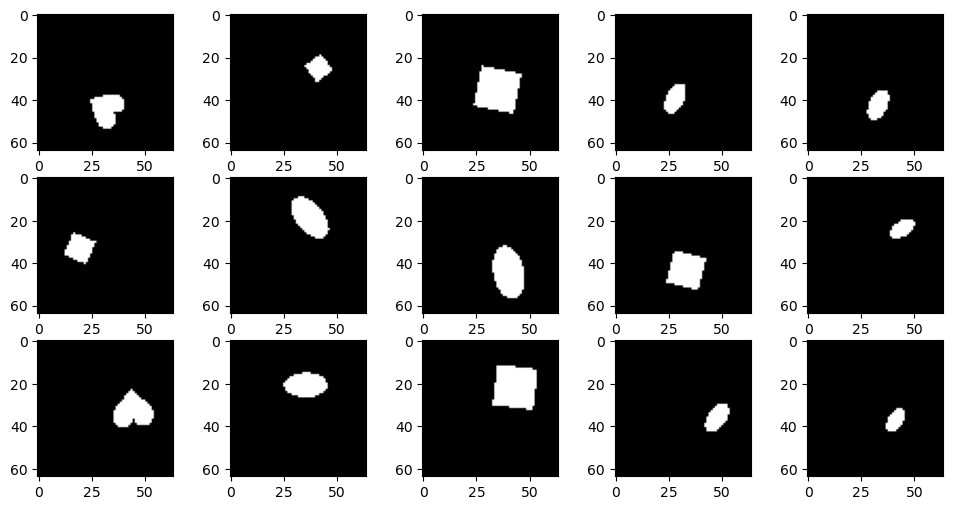

In [7]:
plt.figure(figsize=(12, 6))
for idx in range(0,15):
    plt.subplot(3, 5, idx+1)
    rand_ind = np.random.randint(0,train_dataset.imgs.shape[0])
    plt.imshow(train_dataset.imgs[rand_ind,:,:], cmap='gray')

# Building the VAE backbone

VAEs are probabilistic models, whose expressivity depends on a choice of backbone. Here we opt for a simple CNN that we are going to build step-by-step. First the encoder (inference network), then the decoder (the generative model), then the complete variational auto-encoder.

Let's start with the `Encoder`, which maps a 64x64 image $x_n$ to a Gaussian distribution $q(z|x_n)\triangleq \mathcal{N}(z| \mu_n, \Sigma_n)$ parametrized by a mean $\mu_n\in \mathbb{R}^D$ and a diagonal covariance $\Sigma_n\triangleq \text{diag}(\sigma_n^{(1)2},\dots, \sigma_n^{(D)2})$. The encoder predicts the $\mu_n^{(j)}$ and $\log{\sigma_n^{(j)2}}$ *i.e.*, $D\times 2$ values.



The `Encoder` consists of 4 `nn.Conv2d` layers with 32 output feature maps, 4x4 kernels, stride 2 and padding 1. This is followed by two linear layers. The first layer outputs 256 neurons. The second layer outputs Dx2 values.

*Hint for coding the first linear layer: The feature maps output by the last convolutional layer have spatial dimension 4x4.*

Between each layer (convolutional or linear), ReLu non-linearities are used. No non-linearity is used after the last linear layer as mean values and log-variances can be positive or negative.

In [8]:
class Encoder(nn.Module):

    def __init__(self, latent_dim = 10):
        r"""
        Encoder of the model proposed in [1].
        Expects images of size (1, 64, 64) as input

        Parameters
        ----------
        latent_dim : int
            Dimensionality of latent output.

        References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
        """
        super(Encoder, self).__init__()

        # Layer parameters
        self.latent_dim = latent_dim

        # Shape required to start transpose convs
        self.reshape = (32, 4, 4)

        # Convolutional layers
        kernel_size = 4
        stride = 2
        padding = 1

        self.conv1 = nn.Conv2d(1, 32, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(32, 32, kernel_size, stride, padding)
        self.conv3 = nn.Conv2d(32, 32, kernel_size, stride, padding)
        self.conv4 = nn.Conv2d(32, 32, kernel_size, stride, padding)

        # Fully connected layers
        self.lin1 = nn.Linear(32 * 4 * 4, 256)
        self.lin2 = nn.Linear(256, 2 * latent_dim)

    def forward(self, x):
        '''
        Pass the input image mini-batch through conv, linear layers and
        non-linearities to output a (B,D,2) tensor where B is the mini-batch
        size and D the latent dimension.
        '''
        batch_size = x.size(0)

        # Convolutional layers with ReLu activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Fully connected layer with ReLu activation
        x = x.view(batch_size, -1)
        x = F.relu(self.lin1(x))

        # Fully connected layer for log variance and mean
        x = self.lin2(x)

        # The shape of the output tensor should be BxDx2, where B is the batch
        # size, and D the latent dimension.
        return x.view(batch_size, self.latent_dim, 2)

Next, we turn to the `Decoder`. The `Decoder` is roughly the symmetric of the `Encoder`. It takes a latent code $z\in \mathbb{R}^D$ as input and outputs a 64x64 image that tells us, for each pixel, the probability that this pixel takes value 1 (rather than 0).

The `Decoder` consists of 2 linear layers, followed by 4 transposed convolution (`nn.ConvTranspose2d`) layers, with ReLu non-linearities in between each layer (linear or conv-transpose). The last conv-transpose layer is followed by a sigmoid non-linearity, as it must predict probabilities.

The first linear layer outputs 256 neurons.

The input feature maps for the first conv-transpose layer have shape 32x4x4.

The conv-transpose layers use 4x4 kernels, stride 2, padding 1, and output 32 feature maps, except the last one, which outputs a single probability map.

In [9]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=10):
        r"""
        Decoder of the model proposed in [1].
        Provides images of size (1, 64, 64) as output.


        Parameters
        ----------
        latent_dim : int
            Dimensionality of latent output.

        Model Architecture (transposed for decoder)
        ------------
        - 4 convolutional layers (each with 32 channels), (4 x 4 kernel), (stride of 2)
        - 1 fully connected layer (256 units)
        - Latent distribution:
            - 1 fully connected layer of 20 units (log variance and mean for 10 Gaussians)

        References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
        """
        super(Decoder, self).__init__()

        # Shape required to start transpose convs
        self.reshape = (32, 4, 4)

        # Fully connected layers
        self.lin1 = nn.Linear(latent_dim, 256)
        self.lin2 = nn.Linear(256, 32 * 4 * 4)

        # Convolutional layers
        kernel_size = 4
        stride = 2
        padding = 1

        self.convT1 = nn.ConvTranspose2d(32, 32, kernel_size, stride, padding)
        self.convT2 = nn.ConvTranspose2d(32, 32, kernel_size, stride, padding)
        self.convT3 = nn.ConvTranspose2d(32, 32, kernel_size, stride, padding)
        self.convT4 = nn.ConvTranspose2d(32, 1, kernel_size, stride, padding)

    def forward(self, z):
        batch_size = z.size(0)

        # Fully connected layers with ReLu activations
        x = F.relu(self.lin1(z))
        x = F.relu(self.lin2(x))

        # Reshape
        x = x.view(batch_size, *self.reshape)

        # Convolutional layers with ReLu activations
        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))
        x = F.relu(self.convT3(x))

        # Final conv layer with sigmoid activation
        x = torch.sigmoid(self.convT4(x))

        return x

The last building block is the `VAEModel`, which is a wrapper for the encoder-decoder architecture.

The `forward` takes images `x` as input and performs image reconstruction (auto-encoding). To do so, it maps the images to a distribution in latent space (encoding), samples latent codes according to these distributions (reparametrization trick), then decodes the samples back to image space (decoding/reconstruction). It outputs a dictionary, with keys `stats_qzx` (the mean/log-var values in latent space), `samples_qzx` (the samples $z_n\sim q(z|x_n)$), and `reconstructions` (probability maps).

Other routines are implemented. `sample_pz` and `generate_samples` are used for image generation. `sample_pz` samples latent codes from the prior $\mathcal{N}(0,I_D)$ and `generate_samples` decodes such samples.

In [10]:
class VAEModel(nn.Module):
    def __init__(self, latent_dim):
        """
        Class which defines model and forward pass.

        Parameters
        ----------
        latent_dim : int
            Dimensionality of latent code.
        """
        super(VAEModel, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mean, logvar, mode='sample'):
        """
        Samples from a normal distribution using the reparameterization trick.

        Parameters
        ----------
        mean : torch.Tensor
            Mean of the normal distribution. Shape (batch_size, latent_dim)

        logvar : torch.Tensor
            Diagonal log variance of the normal distribution. Shape (batch_size,
            latent_dim)

        mode : 'sample' or 'mean'
            Returns either a sample from qzx or the mean of qzx. The former is
            useful at training time. The latter is useful at inference time as
            the mean is usually used for reconstruction, rather than a sample.
        """
        if mode=='sample':
            # Implements the reparametrization trick (slide 43):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + eps * std
        elif mode=='mean':
            return mean
        else:
            return ValueError("Unknown mode: {mode}".format(mode))

    def forward(self, x, mode='sample'):
        """
        Forward pass of model, used for training or reconstruction.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)

        mode : 'sample' or 'mean'
            Reconstructs from either a sample from qzx or the mean of qzx
        """

        # stats_qzx is the output of the encoder
        stats_qzx = self.encoder(x)

        # Use the reparametrization trick to sample from q(z|x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1), mode=mode)

        # Decode the samples to image space
        reconstructions = self.decoder(samples_qzx)

        # Return everything:
        return {
            'reconstructions': reconstructions,
            'stats_qzx': stats_qzx,
            'samples_qzx': samples_qzx}

    def sample_qzx(self, x):
        """
        Returns a sample z from the latent distribution q(z|x).

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        stats_qzx = self.encoder(x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1))
        return samples_qzx

    def sample_pz(self, N):
        samples_pz = torch.randn(N, self.latent_dim, device=self.encoder.conv1.weight.device)
        return samples_pz

    def generate_samples(self, samples_pz=None, N=None):
        if samples_pz is None:
            if N is None:
                return ValueError("samples_pz and N cannot be set to None at the same time. Specify one of the two.")

            # If samples z are not provided, we sample N samples from the prior
            # p(z)=N(0,Id), using sample_pz
            samples_pz = self.sample_pz(N)

        # Decode the z's to obtain samples in image space (here, probability
        # maps which can later be sampled from or thresholded)
        generations = self.decoder(samples_pz)
        return {'generations': generations}

# Loss functions for the VAE

The VAE relies on two losses: a reconstruction loss `reconstruction_loss` and a regularization term `kl_normal_loss` (KL divergence, here between $q(z|x_n)$ and $\mathcal{N}(0,1)$). Together they give the formula on slide 45.

The reconstruction loss translates a pixel-wise Bernoulli probabilistic model into a loss (`F.binary_cross_entropy`). It takes input images `data` and reconstructed probability maps `reconstructions` and computes the binary cross-entropy, from the two images.

In [11]:
def reconstruction_loss(data, reconstructions):
    """
    Calculates the per image reconstruction loss for a batch of data. I.e. negative
    log likelihood.

    Parameters
    ----------
    data : torch.Tensor
        Input data (e.g. batch of images). Shape : (batch_size, 1,
        height, width).

    reconstructions : torch.Tensor
        Reconstructed data. Shape : (batch_size, 1, height, width).

    Returns
    -------
    loss : torch.Tensor
        Cross entropy (i.e. averaged over images in the batch but summed over
        pixel and channel)
    """
    batch_size, n_chan, height, width = reconstructions.size()

    # The pixel-wise loss is the binary cross-entropy, computed from
    # reconstructions and data. It is summed over pixels and averaged across
    # samples in the batch.
    loss = F.binary_cross_entropy(reconstructions, data, reduction = 'sum') / batch_size

    return loss

The KL divergence term is computed as per the regularization term in slide 45 i.e., for each data sample in the mini-batch:
$$\frac{1}{2}\sum_{j=1}^D (\mu_j^2 + \sigma_j^2 - 1 - \log{\sigma_j^2})$$

In [12]:
def kl_normal_loss(mean, logvar, batch_mean=True, component_sum=True):
    """
    Calculates the KL divergence between a normal distribution
    with diagonal covariance and a unit normal distribution.

    Parameters
    ----------
    mean : torch.Tensor
        Mean of the normal distribution. Shape (batch_size, latent_dim) where
        D is dimension of distribution.

    logvar : torch.Tensor
        Diagonal log variance of the normal distribution. Shape (batch_size,
        latent_dim)

    batch_mean: boolean
        If false, returns a separate value for each data point, if true takes
        the mean over data points

    component_sum: boolean
        If false, returns a separate value for each latent dimension, if true
        takes the sum over latent dimensions
    """
    # kl for each latent dimension and each q(z|x_n) for n in the batch i.e.,
    # the summand of the above equation for each data sample
    # Tensor of size (B, D) where B is the batch size and D the latent dim.
    latent_kl = 0.5 * (mean**2 + torch.exp(logvar) - 1 - logvar)

    if batch_mean:
        latent_kl = latent_kl.mean(dim=0)

    if component_sum:
        latent_kl = latent_kl.sum(dim=-1)

    return latent_kl

The `BetaVAELoss` puts it all together as per slide 55.

In [13]:
class BetaVAELoss(object):
    """
    Compute the Beta-VAE loss as in [1]

    Parameters
    ----------
    beta: (scalar) the weight assigned to the regularization term

    References
    ----------
        [1] Burgess, Christopher P., et al. "Understanding disentangling in
        $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """

    def __init__(self, beta):
        self.beta = beta

    def __call__(self, data, reconstructions, stats_qzx):
        stats_qzx = stats_qzx.unbind(-1)

        # Reconstruction loss
        rec_loss = reconstruction_loss(data, reconstructions)

        # KL loss
        kl_loss = kl_normal_loss(*stats_qzx)

        # Total loss of beta-VAE
        loss = rec_loss + self.beta * kl_loss

        return loss

# Training the VAE model

Everything is in place to train our VAE model on the dSprites training data. We use a latent space of dimension 10. We use the `BetaVAELoss`.

You can train on CPU or GPU. The code makes sure that the model and data are automatically ported on GPU if it is available, otherwise the CPU will be used. Training on CPU is roughly 10-20x slower here.

In [14]:
D = 10

learning_rate = 1e-3
batch_size = 64

n_epoch = 10

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Instantiate a VAE model (with random weights) and latent dimension `D`:

In [16]:
model = VAEModel(D)

In [17]:
model = model.to(device)

We instantiate a data loader to use the training data, with mini-batch size given by `batch_size`.

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

Instantiate a `BetaVAELoss` object with value `beta=1.`:

In [19]:
vae_loss = BetaVAELoss(beta = 1.)

We instantiate an optimizer `torch.optim.AdamW`, taking the `VAEModel` parameters as trainable parameters and with the `learning_rate` fixed above.

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = 1e-4)

We can now start the training, putting it all together.

In [21]:
model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm(train_loader, unit="batch") as tepoch:
    for data, factors in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device, GPU or CPU
      data = data.to(device)

      # Pass the input data through the model
      predict = model(data)
      reconstructions = predict['reconstructions']
      stats_qzx = predict['stats_qzx']

      # Compute the beta-VAE loss
      loss = vae_loss(data, reconstructions, stats_qzx)

      # Backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Aggregate the training loss for display at the end of the epoch
      train_loss += loss.item()

      # tqdm bar displays the loss
      tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(train_loader)))

Epoch 0: 100%|██████████| 8640/8640 [00:56<00:00, 153.22batch/s, loss=90.5]


Epoch 0: Train Loss: 125.3454


Epoch 1: 100%|██████████| 8640/8640 [00:55<00:00, 156.95batch/s, loss=69.5]


Epoch 1: Train Loss: 74.5215


Epoch 2: 100%|██████████| 8640/8640 [00:54<00:00, 157.31batch/s, loss=59.4]


Epoch 2: Train Loss: 62.7863


Epoch 3: 100%|██████████| 8640/8640 [00:53<00:00, 162.37batch/s, loss=58.1]


Epoch 3: Train Loss: 57.5334


Epoch 4: 100%|██████████| 8640/8640 [00:53<00:00, 162.84batch/s, loss=49.4]


Epoch 4: Train Loss: 54.3927


Epoch 5: 100%|██████████| 8640/8640 [00:53<00:00, 160.99batch/s, loss=51]  


Epoch 5: Train Loss: 52.2442


Epoch 6: 100%|██████████| 8640/8640 [00:56<00:00, 153.47batch/s, loss=46.9]


Epoch 6: Train Loss: 50.5708


Epoch 7: 100%|██████████| 8640/8640 [00:55<00:00, 154.82batch/s, loss=47.5]


Epoch 7: Train Loss: 49.3008


Epoch 8: 100%|██████████| 8640/8640 [00:53<00:00, 160.39batch/s, loss=51.5]


Epoch 8: Train Loss: 48.2797


Epoch 9: 100%|██████████| 8640/8640 [00:55<00:00, 154.78batch/s, loss=46.9]

Epoch 9: Train Loss: 47.4287


# Testing the VAE model

We can now test the performance of the VAE model in qualitative terms, both regarding image reconstruction and image generation.

In [22]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

We'll store the reconstructed images for all data samples in the test dataset in `test_reconstructions`:

In [23]:
test_reconstructions = np.zeros((len(test_dataset), 64, 64), dtype=np.uint)

In [24]:
model.eval()
test_loss=0.0

n = 0
with tqdm(test_loader, unit="batch") as tepoch:
  for data, factors in tepoch:
    # Put the data on the correct device:
    data = data.to(device)

    # Pass the data through the model
    predict = model(data, mode='mean')
    reconstructions = predict['reconstructions']
    stats_qzx = predict['stats_qzx']

    # Compute the beta-VAE loss
    loss = vae_loss(data, reconstructions, stats_qzx)

    # Store quantities of interest
    # This time, we want to store reconstructed images obtained by thresholding
    # the probability map reconstructions at value 0.5, then multiplying the
    # resulting map by 255 to obtain an integer image taking value 0 or 255
    # at every pixel.
    # Using .detach().cpu().numpy(), the image will be stored as a np.array on
    # CPU.
    batch_size = stats_qzx.shape[0]
    test_reconstructions[n:(n+batch_size), :, :] = (reconstructions[:, 0, :, :] > 0.5).detach().cpu().numpy().astype(np.uint8) * 255

    # Compute the loss
    test_loss += loss.item()

    # tqdm bar displays the loss
    tepoch.set_postfix(loss=loss.item())

    # increment n to fill next parts of the arrays
    n += stats_qzx.shape[0]

print('Test Loss: {:.4f}'.format(test_loss/len(test_loader)))

100%|██████████| 173/173 [00:00<00:00, 207.85batch/s, loss=43.7]

Test Loss: 42.9797


We can now visualize the input test images side to side with their reconstructions, for a random subset of 8 images. We will evaluate the reconstruction performance quantitatively in the second part of the lab.

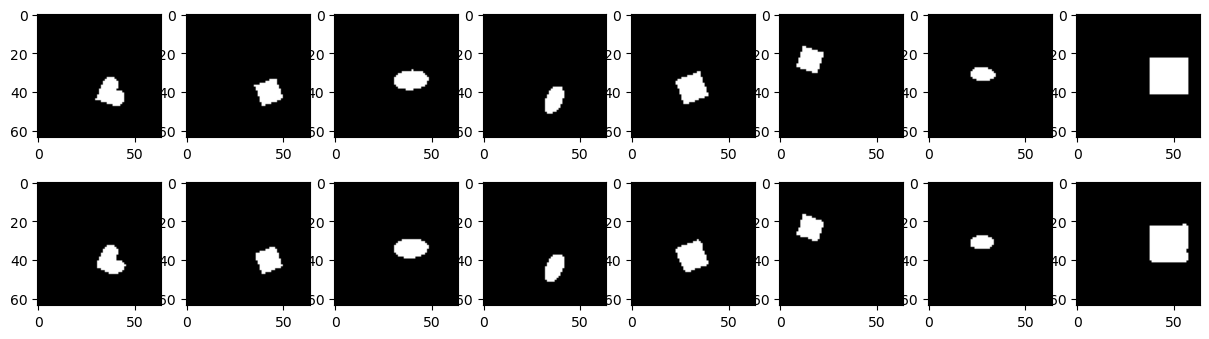

In [25]:
plt.figure(figsize=(15, 4))
for idx in range(0,8):
    rand_ind = np.random.randint(0,len(test_dataset))

    plt.subplot(2, 8, idx+1)
    plt.imshow(test_dataset.imgs[rand_ind,:,:], cmap='gray')

    plt.subplot(2, 8, 8+idx+1)
    plt.imshow(test_reconstructions[rand_ind,:,:], cmap='gray')

Finally, we want to evaluate qualitatively the generative ability of the model. Synthetize 8 images using `generate_samples` from the `VAEModel` class.

`generate_sample` actually generates probability maps. Again threshold them at probability 0.5, multiply by 255 to obtain integer images, and store them as a numpy array on CPU (in `generated_images`).

In [26]:
# This should be an (8, 64, 64) np.array:
generated_images = model.generate_samples(N=8)['generations'].detach().cpu().numpy()
generated_images = (generated_images[:, 0, :, :] > 0.5).astype(np.uint8) * 255

We can visualize the generated images.

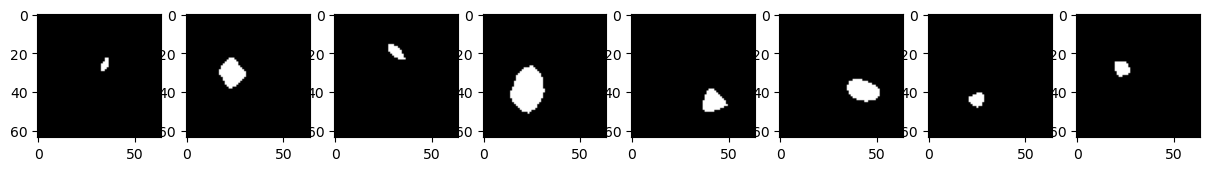

In [27]:
plt.figure(figsize=(15, 3))
for idx in range(0,8):
    plt.subplot(1, 8, idx+1)
    plt.imshow(generated_images[idx,:,:], cmap='gray')

We can see visually that the generated images are far from perfect.

To assign a quantitative score for the generative performance, we could use the FID score. This would involve
* loading a pretrained InceptionV3 model,
* passing a number (say, 1000) of real test images through the network and recording their embeddings,
* similarly passing 1000 generated images through the network and recording their embeddings,
* from the embeddings of the real test images (resp. generated images), computing statistics (mean + variance)
* comparing the statistics of the real test images and of the generated images according to slide 54.

Note that images have to be standardized according to the expected preprocessing of InceptionV3 before passing them through the network. In our case, InceptionV3 expects 3-channel color images in a certain range of values ([0,1]) and applies a rescaling (mean/std) to the images before inputting them to the network. This pipeline has to be respected.

We do not do it here. This is left as completely optional work (do not do it unless you have finished the rest of the lab!). **BONUS:** compute the FID score for your trained VAE model, using `len(test_dataset)` images to compute the statistics.

# Second part: comparing models

We will now compare different $\beta$-VAE models, obtained for different values of the hyperparameter $\beta$, in terms of image reconstruction capability and disentanglement (and also visual quality of the generated images).

We will also add to the comparison a model trained with an Annealed VAE similar to the framework presented in slide 63.

(The models have been trained on 75% of the dSprites dataset, for roughly 10 epochs each.)

In [28]:
D = 10

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Loading model `model_001` for $\beta := 10^{-2}$

In [30]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1bV9BhY7B_K3fuco5FvVlrqy3usrONJCF' -O weights_001.pth

if torch.cuda.is_available():
  weights_dict = torch.load('weights_001.pth')
else:
  weights_dict = torch.load('weights_001.pth', map_location=torch.device('cpu'))

model_001 = VAEModel(latent_dim=D)
model_001.load_state_dict(weights_dict)
model_001 = model_001.to(device)
model_001.eval()

will be placed in the single file you specified.

--2025-03-04 17:07:32--  https://drive.google.com/uc?export=download&id=1bV9BhY7B_K3fuco5FvVlrqy3usrONJCF
Resolving drive.google.com (drive.google.com)... 142.250.179.110, 2a00:1450:4007:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1bV9BhY7B_K3fuco5FvVlrqy3usrONJCF&export=download [following]
--2025-03-04 17:07:33--  https://drive.usercontent.google.com/download?id=1bV9BhY7B_K3fuco5FvVlrqy3usrONJCF&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.179.97, 2a00:1450:4007:818::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.179.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489737 (1.4M) [application/octet-stream]
Saving to: ‘weights_001.pth’

weights_001.pth     

/tmp/ipykernel_1615526/2506290978.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_001.pth')


VAEModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=10, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Loading model `model_01` for $\beta := 10^{-1}$

In [31]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1tCozYj12l-WiZk-JB9GsqRm1YZ8VKprO' -O weights_01.pth

if torch.cuda.is_available():
  weights_dict = torch.load('weights_01.pth')
else:
  weights_dict = torch.load('weights_01.pth', map_location=torch.device('cpu'))

model_01 = VAEModel(latent_dim=D)
model_01.load_state_dict(weights_dict)
model_01 = model_01.to(device)
model_01.eval()

will be placed in the single file you specified.

--2025-03-04 17:07:36--  https://drive.google.com/uc?export=download&id=1tCozYj12l-WiZk-JB9GsqRm1YZ8VKprO
Resolving drive.google.com (drive.google.com)... 142.250.179.110, 2a00:1450:4007:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1tCozYj12l-WiZk-JB9GsqRm1YZ8VKprO&export=download [following]
--2025-03-04 17:07:36--  https://drive.usercontent.google.com/download?id=1tCozYj12l-WiZk-JB9GsqRm1YZ8VKprO&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.179.97, 2a00:1450:4007:818::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.179.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489737 (1.4M) [application/octet-stream]
Saving to: ‘weights_01.pth’

weights_01.pth      1

/tmp/ipykernel_1615526/2334563060.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_01.pth')


VAEModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=10, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Loading model `model_1` for $\beta := 1.$

In [32]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1kBoLftBkhdEjNe-ObLmX-WjOrISJFerR' -O weights_1.pth

if torch.cuda.is_available():
  weights_dict = torch.load('weights_1.pth')
else:
  weights_dict = torch.load('weights_1.pth', map_location=torch.device('cpu'))

model_1 = VAEModel(latent_dim=D)
model_1.load_state_dict(weights_dict)
model_1 = model_1.to(device)
model_1.eval()

will be placed in the single file you specified.

--2025-03-04 17:07:40--  https://drive.google.com/uc?export=download&id=1kBoLftBkhdEjNe-ObLmX-WjOrISJFerR
Resolving drive.google.com (drive.google.com)... 142.250.179.110, 2a00:1450:4007:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1kBoLftBkhdEjNe-ObLmX-WjOrISJFerR&export=download [following]
--2025-03-04 17:07:41--  https://drive.usercontent.google.com/download?id=1kBoLftBkhdEjNe-ObLmX-WjOrISJFerR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.179.97, 2a00:1450:4007:818::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.179.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489711 (1.4M) [application/octet-stream]
Saving to: ‘weights_1.pth’

weights_1.pth       10

/tmp/ipykernel_1615526/811810230.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_1.pth')


VAEModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=10, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Loading model `model_3` for $\beta:=3$

In [33]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1q3cdDl46IiX2ZG416a0DGvKmwzjCDz9F' -O weights_3.pth

if torch.cuda.is_available():
  weights_dict = torch.load('weights_3.pth')
else:
  weights_dict = torch.load('weights_3.pth', map_location=torch.device('cpu'))

model_3 = VAEModel(latent_dim=D)
model_3.load_state_dict(weights_dict)
model_3 = model_3.to(device)
model_3.eval()

will be placed in the single file you specified.

--2025-03-04 17:07:44--  https://drive.google.com/uc?export=download&id=1q3cdDl46IiX2ZG416a0DGvKmwzjCDz9F
Resolving drive.google.com (drive.google.com)... 142.250.179.110, 2a00:1450:4007:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1q3cdDl46IiX2ZG416a0DGvKmwzjCDz9F&export=download [following]
--2025-03-04 17:07:44--  https://drive.usercontent.google.com/download?id=1q3cdDl46IiX2ZG416a0DGvKmwzjCDz9F&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.179.97, 2a00:1450:4007:818::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.179.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489737 (1.4M) [application/octet-stream]
Saving to: ‘weights_3.pth’

weights_3.pth       10

/tmp/ipykernel_1615526/3713738057.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_3.pth')


VAEModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=10, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Loading model `model_10` for $\beta := 10$

In [34]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1IljU8BHfedXHNHzrPCe4ERUDo_Tnxh3s' -O weights_10.pth

if torch.cuda.is_available():
  weights_dict = torch.load('weights_10.pth')
else:
  weights_dict = torch.load('weights_10.pth', map_location=torch.device('cpu'))

model_10 = VAEModel(latent_dim=D)
model_10.load_state_dict(weights_dict)
model_10 = model_10.to(device)
model_10.eval()

will be placed in the single file you specified.

--2025-03-04 17:07:48--  https://drive.google.com/uc?export=download&id=1IljU8BHfedXHNHzrPCe4ERUDo_Tnxh3s
Resolving drive.google.com (drive.google.com)... 142.250.179.110, 2a00:1450:4007:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IljU8BHfedXHNHzrPCe4ERUDo_Tnxh3s&export=download [following]
--2025-03-04 17:07:48--  https://drive.usercontent.google.com/download?id=1IljU8BHfedXHNHzrPCe4ERUDo_Tnxh3s&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.179.97, 2a00:1450:4007:818::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.179.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489711 (1.4M) [application/octet-stream]
Saving to: ‘weights_10.pth’

weights_10.pth      1

/tmp/ipykernel_1615526/1016282216.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_10.pth')


VAEModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=10, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Loading model `model_100` for $\beta := 100$

In [35]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1K1SMnENlZwo5pv-Xlct8aqpX-06sK6ZL' -O weights_100.pth

if torch.cuda.is_available():
  weights_dict = torch.load('weights_100.pth')
else:
  weights_dict = torch.load('weights_100.pth', map_location=torch.device('cpu'))

model_100 = VAEModel(latent_dim=D)
model_100.load_state_dict(weights_dict)
model_100 = model_100.to(device)
model_100.eval()

will be placed in the single file you specified.

--2025-03-04 17:07:52--  https://drive.google.com/uc?export=download&id=1K1SMnENlZwo5pv-Xlct8aqpX-06sK6ZL
Resolving drive.google.com (drive.google.com)... 142.250.179.110, 2a00:1450:4007:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1K1SMnENlZwo5pv-Xlct8aqpX-06sK6ZL&export=download [following]
--2025-03-04 17:07:52--  https://drive.usercontent.google.com/download?id=1K1SMnENlZwo5pv-Xlct8aqpX-06sK6ZL&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.179.97, 2a00:1450:4007:818::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.179.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489914 (1.4M) [application/octet-stream]
Saving to: ‘weights_100.pth’

weights_100.pth     

/tmp/ipykernel_1615526/2228901934.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_100.pth')


VAEModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=10, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Loading model `model_annealed` for $\beta$ progressively annealed from $100$ to $10^{-2}$

In [37]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=174oYfjI-jRuwIkDuccgHLW7hUFZ2tMy3' -O weights_annealed.pth

if torch.cuda.is_available():
  weights_dict = torch.load('weights_annealed.pth')
else:
  weights_dict = torch.load('weights_annealed.pth', map_location=torch.device('cpu'))

model_annealed = VAEModel(latent_dim=D)
model_annealed.load_state_dict(weights_dict)
model_annealed = model_annealed.to(device)
model_annealed.eval()

will be placed in the single file you specified.

--2025-03-04 17:08:27--  https://drive.google.com/uc?export=download&id=174oYfjI-jRuwIkDuccgHLW7hUFZ2tMy3
Resolving drive.google.com (drive.google.com)... 142.250.179.110, 2a00:1450:4007:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=174oYfjI-jRuwIkDuccgHLW7hUFZ2tMy3&export=download [following]
--2025-03-04 17:08:27--  https://drive.usercontent.google.com/download?id=174oYfjI-jRuwIkDuccgHLW7hUFZ2tMy3&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.179.97, 2a00:1450:4007:818::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.179.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1490035 (1.4M) [application/octet-stream]
Saving to: ‘weights_annealed.pth’

weights_anneale

/tmp/ipykernel_1615526/1338709773.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_annealed.pth')


VAEModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=10, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

We are going to compute the predictions of all 7 loaded models on the test dataset. We store the reconstructed probability maps in `test_reconstructions_mean`, the thresholded images in `test_reconstructions_image`, the latent distributions (mean/log-var) corresponding to each sample in `test_stats_qzx`. We also record the corresponding ground truth factor values ('shape', 'scale', 'orientation', 'posX', 'posY') for each data sample, in `gt_factors`.

In [38]:
models = [model_001, model_01, model_1, model_3, model_10, model_100, model_annealed]
model_descriptions = ['0.01', '0.1', '1', '3', '10', '100', 'ann.']

In [39]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [40]:
test_reconstructions_mean = torch.zeros((7,len(test_dataset), 64, 64))
test_reconstructions_image = np.zeros((7,len(test_dataset), 64, 64), dtype=np.uint)
test_stats_qzx = torch.zeros(7,len(test_dataset), D, 2)
gt_factors = torch.zeros(7, len(test_dataset), 5)

In [41]:
for i,model in enumerate(models):
  n = 0
  with tqdm(test_loader, unit="batch") as tepoch:
    for data, factors in tepoch:
      tepoch.set_description("Model 𝛽={}".format(model_descriptions[i]))

      # Move data to GPU
      data = data.to(device)

      # Compute predictions
      predict = model(data, mode='mean')
      reconstructions = predict['reconstructions']
      stats_qzx = predict['stats_qzx']

      # Store quantities of interest
      batch_size = stats_qzx.shape[0]
      gt_factors[i,n:(n+batch_size),:] = factors
      test_stats_qzx[i,n:(n+batch_size),:,:] = stats_qzx.detach()
      test_reconstructions_mean[i,n:(n+batch_size), :, :] = reconstructions.detach().cpu().squeeze()
      test_reconstructions_image[i,n:(n+batch_size), :, :] = (reconstructions[:, 0, :, :].detach().cpu().numpy() >= 0.5)*255

      # increment n to fill next parts of the arrays
      n += batch_size

Model 𝛽=ann.: 100%|██████████| 173/173 [00:01<00:00, 172.75batch/s]


Next, we visualize both the reconstruction and generation performance of all 7 models. Each model occupies a single row (1st row: '0.01', 2nd row: '0.1', 3rd row: '1', 4th row: '3', 5th row: '10', 6th row: '100', 7th row: 'ann.').

We randomly pick 3 images from the test set. For each model (each row), we display each original test image, their reconstruction, and a random generated image (unrelated to the test image). (That leads to 3x3=9 images per row).



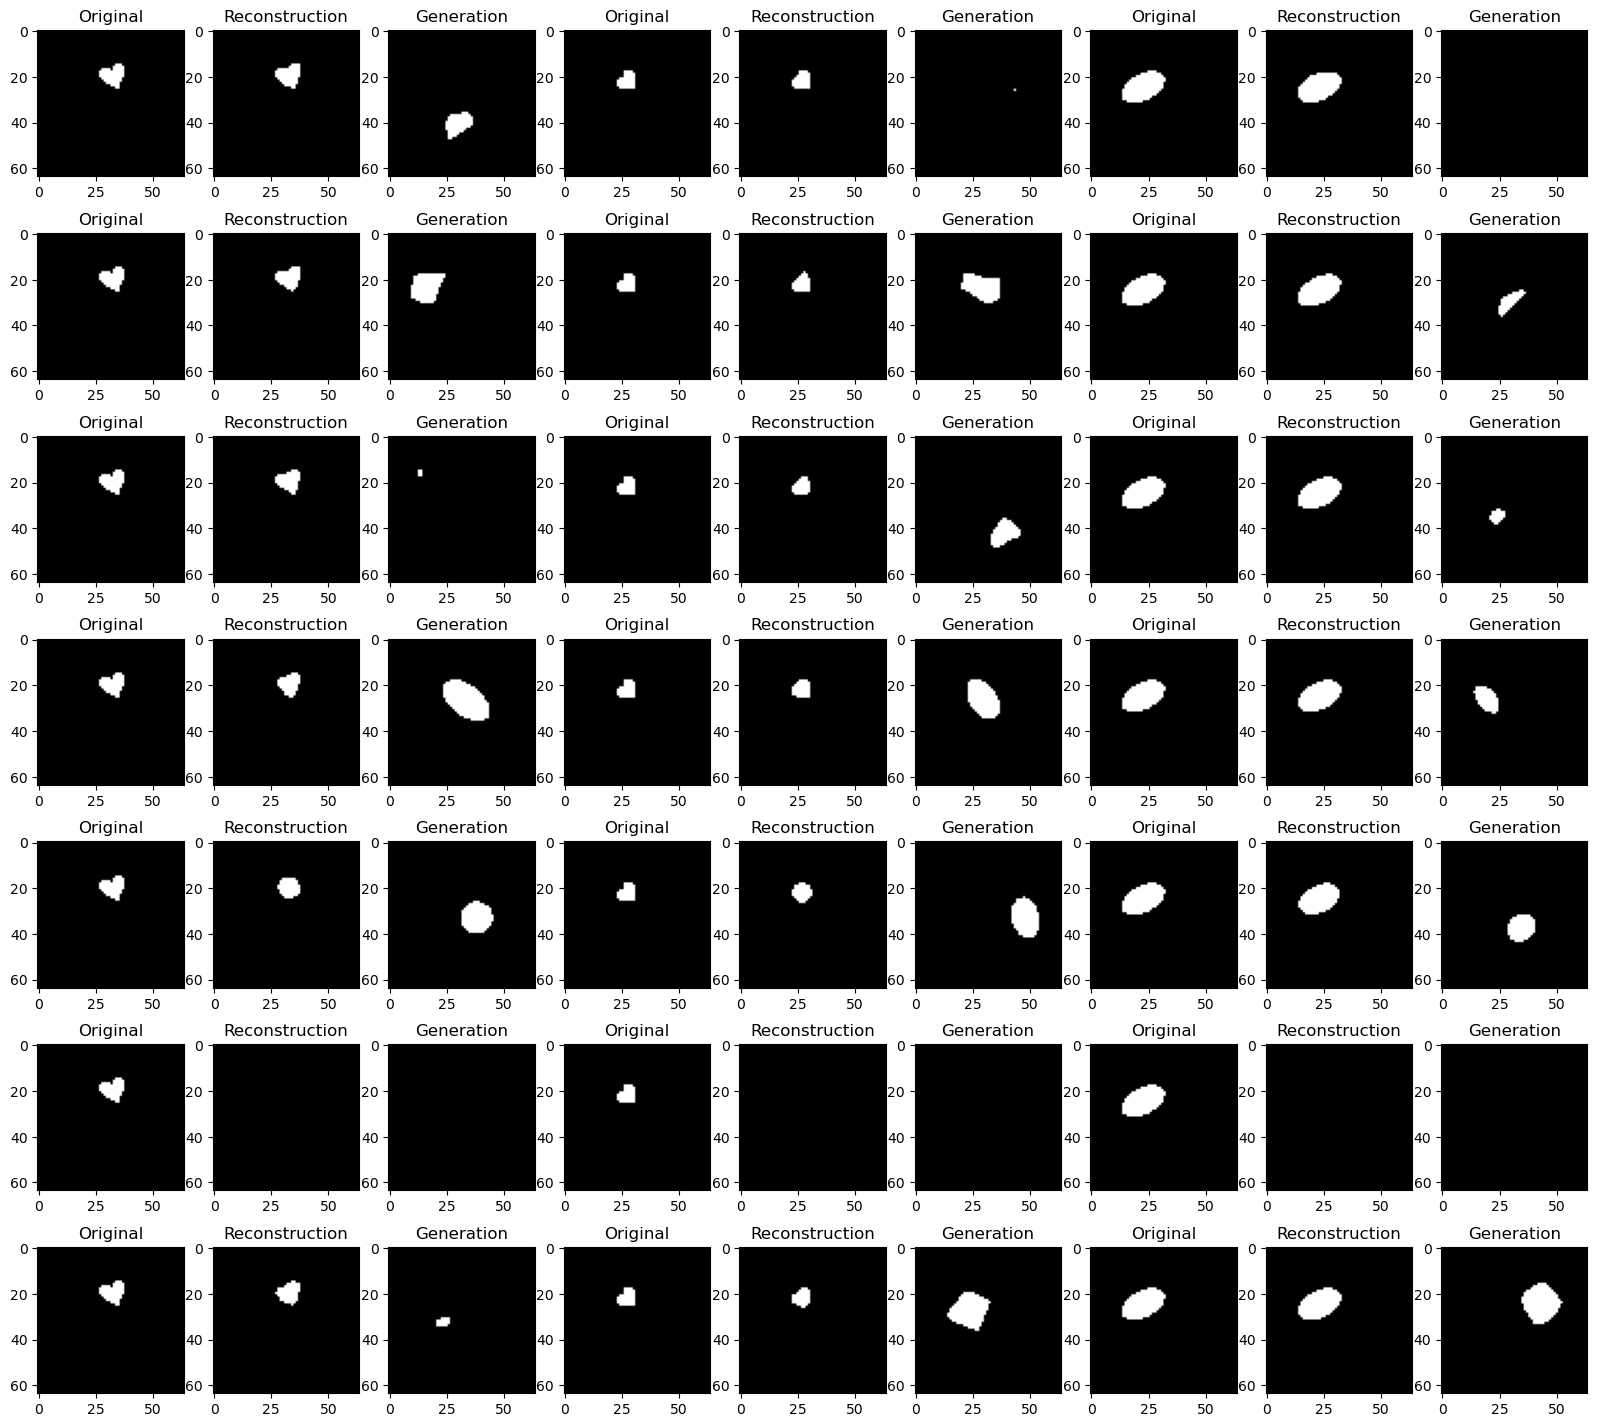

In [42]:
plt.figure(figsize=(20, 18))
for img in range(0,3):
    rand_ind = np.random.randint(0,len(test_dataset))

    for mdl in range(0,7):
        plt.subplot(7, 9, 9*mdl+3*img+1)
        plt.imshow(test_dataset.imgs[rand_ind,:,:], cmap='gray')
        plt.title("Original")

        plt.subplot(7, 9, 9*mdl+3*img+2)
        plt.imshow(test_reconstructions_image[mdl,rand_ind,:,:], cmap='gray')
        plt.title("Reconstruction")

        generated_image = (models[mdl].generate_samples(N=1)['generations'].detach().cpu().numpy().squeeze() >= 0.5) * 255
        plt.subplot(7, 9, 9*mdl+3*img+3)
        plt.imshow(generated_image, cmap='gray')
        plt.title("Generation")

**Questions:**
1. Which models do you think show the best reconstructions? the best generations? The best compromise between both?

2. How do you explain the 'empty' reconstructions for the model $\beta=10^2$ (6th row)?

3. How do you explain the particularly poor generated images for $\beta=10^{-2}$, $\beta=10^{-1}$ (1st and 2nd rows)?

You can run the above cell several times to better inform your answers / avoid 'chance' outputs.

**Answers**:

1. We see above that the models with a low value of $\beta$ show rather good reconstructions. For larger $\beta$, the squares tend to become circles for instance. This is logical, since the loss is $\text{reconstruction loss} + \beta \text{ kl loss}$: for a low $\beta$, the loss is mostly equal to the reconstruction loss.

For the generation, none of the models is really good. Based on the same argument as before, we would be tempted to believe that higher values of $\beta$ lead to more structured latent spaces, hence better generated images. But when $\beta$ is really high, the generated images are not varied at all, we mostly observe sorts of circles.

The annealed model shows rather good results for both the reconstruction (though some details are lost) and the generation (we sometimes get things that vaguely ressemble hearts). 

2. For very large values of $\beta$, the KL divergence term in the loss function dominates. This forces the latent distribution to be close to a Gaussian, and we can essentially lose most of the information from the input image. Therefore the decoder is given pretty much no relevant information, and generates nothing relevant, which can be, through the activation functions, turned into 0.

3. For very low values of $\beta$, the model prioritizes reconstruction over learning a well-structured latent space. Therefore the reconstructions are accurate, but the latent space does not learn a meaningful or disentangled representation. This can lead to unrealistic and poor-quality generated images.

## Quantitative metrics

Next, we are going to quantify model performance according to two metrics: one reconstruction metric, and one disentanglement metric. Ideally we would like models with low reconstruction error, and high disentanglement score.

We first provide the **reconstruction metric** `ReconstructionMetric`. It computes, per test image, the average log-likelihood of a pixel (averaged over all pixels) under a model. To do so, it takes as input the reconstructed probability maps and the original test images. The lower the metric, the better reconstruction.

In [43]:
class ReconstructionMetric(object):
    def __init__(self):
        super().__init__()

    def __call__(self, reconstructions, data):
        """
        Reconstruction error per image, averaged over pixels.
        (Returns a list of the same length as there are images)
        """
        return torch.mean(
                  F.binary_cross_entropy(reconstructions, data,
                                         reduction='none').view(len(data), -1),
                  dim=-1)

From the metric above, compute for all 7 models their reconstruction score (taking the average over all test images to get a single scalar value per model):

In [44]:
reconstruction_scores = torch.zeros(7)

reconstruction_metric = ReconstructionMetric()

for i,model in enumerate(models):
    # Reconstruction score for model i (average over all test images):
    reconstruction_scores[i] = reconstruction_metric(test_reconstructions_mean[i], torch.tensor(test_dataset.imgs * 1., dtype = torch.float32)).mean()

In [45]:
for i in range(7):
    print("Model 𝛽={}: {}".format(model_descriptions[i],reconstruction_scores[i]))

Model 𝛽=0.01: 0.0035093820188194513
Model 𝛽=0.1: 0.0032430337741971016
Model 𝛽=1: 0.004613323602825403
Model 𝛽=3: 0.00630140257999301
Model 𝛽=10: 0.01814744994044304
Model 𝛽=100: 0.1380128711462021
Model 𝛽=ann.: 0.005736054852604866


We will now **implement the 'Mutual Information Gap'** metric from slide 77, which is an information-theoretic based disentanglement metric.

To do so, we will quantize/discretize latent codes and ground truth factors, as it is much easier to compute the mutual information of discrete random variables.

To compute the MIG score, we will need to compute the entropy of ground truth generative factors `vk`, caracterized by their empirical distributions *i.e.*, vectors of discrete values. This is done by the `entropy` routine below.

We will also need to compute the mutual information of two discrete random variables `zi` and `vk` characterized empirically by two paired vectors of discrete values (i.e., `zi` and `vk` are two vectors of the same length, where value `j` in each vector corresponds to the value of the variable for the `j`th data sample). This can be done using `sklearn.metrics.mutual_info_score(zi, vk)`.

In [46]:
def entropy(labels):
    """
    Copy-paste from sklearn.metrics.

    Calculate the entropy for a labeling.

    Parameters
    ----------
    labels : array-like of shape (n_samples,), dtype=int
        The labels.

    Returns
    -------
    entropy : float
       The entropy for a labeling.

    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]

    # single cluster => zero entropy
    if pi.size == 1:
        return 0.0

    pi_sum = np.sum(pi)
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))

Complete the missing parts in `MIGMetric` below:

In [47]:
class MIGMetric(object):
    def __init__(self, num_bins=20):
        super().__init__()
        self.num_bins = num_bins

    def __call__(self, stats_qzx, gt_factors):
        """Compute the mutual information gap as in [1].

        References
        ----------
           [1] Chen, Tian Qi, et al. "Isolating sources of disentanglement in variational
           autoencoders." Advances in Neural Information Processing Systems. 2018.
        """

        # Torch to numpy conversion
        if isinstance(stats_qzx, torch.Tensor):
            stats_qzx = [x.detach().cpu().numpy() for x in stats_qzx.unbind(-1)]
        mean_qzx = stats_qzx[0]
        if isinstance(gt_factors, torch.Tensor):
            gt_factors = gt_factors.detach().cpu().numpy()

        num_latents = mean_qzx.shape[-1]
        num_factors = gt_factors.shape[-1]

        # Rescaling the factors and latent variables does not change their mutual information or entropy,
        # but it will let us quantize them via bins
        mean_qzx = sklearn.preprocessing.minmax_scale(mean_qzx) # (N,D) array, this contains the z_i's for all i and all N test samples
        gt_factors = sklearn.preprocessing.minmax_scale(gt_factors) # (N,K) array, this contains the v_k's for all k and all N test samples

        # Quantization, we turn them in discrete variables to compute the mutual information and
        # entropy more easily below:
        bins = np.linspace(0, 1, self.num_bins + 1)
        mean_qzx = np.digitize(mean_qzx, bins[:-1], right=False).astype(int) # (N,D) array, this contains the quantized z_i's for all i and all N test samples
        gt_factors = np.digitize(gt_factors, bins[:-1], right=False).astype(int) # (N,K) array, this contains the quantized v_k's for all k and all N test samples

        # Compute a (D,K) array of mutual informations between each pair of (z_i,v_k)
        # Hint: look at the definition of mean_qzx and gt_factors above and use them
        mutual_info_scores = np.zeros((num_latents, num_factors))
        for i in range(num_latents):
            for k in range(num_factors):
                mutual_info_scores[i,k] = sklearn.metrics.mutual_info_score(mean_qzx[:, i], gt_factors[:, k])

        # Sorting each column of this (D,K) array in ascending order:
        sorted_factor_mutual_info_scores = np.sort(mutual_info_scores, axis=0)

        # Taking the difference, column-wise, of the highest and second highest MI scores
        mutual_info_gaps = sorted_factor_mutual_info_scores[-1, :] - sorted_factor_mutual_info_scores[-2, :]

        # Computing the entropy of each generative factor v_k to normalize the MI gaps
        factor_entropy = np.zeros((num_factors,))
        for k in range(num_factors):
            factor_entropy[k] = entropy(gt_factors[:,k])

        # Normalizing the gaps and averaging over factors as in slide 77
        normalized_mutual_info_gap = mutual_info_gaps / (factor_entropy + 1e-12)

        return normalized_mutual_info_gap.mean()

We can now compute the MIG score of all 7 models and print them:

In [48]:
mig_scores = np.zeros(7)
mig_metric = MIGMetric()

for i,model in enumerate(models):
    mig_scores[i] = mig_metric(test_stats_qzx[i], gt_factors[i])

In [49]:
for i in range(7):
    print("Model 𝛽={}: {}".format(model_descriptions[i],mig_scores[i]))

Model 𝛽=0.01: 0.021118065442571166
Model 𝛽=0.1: 0.01760190138840343
Model 𝛽=1: 0.057288672761765844
Model 𝛽=3: 0.09289077019234608
Model 𝛽=10: 0.2255274197819896
Model 𝛽=100: 0.0
Model 𝛽=ann.: 0.3468619191525786


**Questions:**
1. Which models are best for reconstruction? For disentanglement?
2. Why is the disentanglement metric going down to 0 for $\beta=100$?
3. Which model do you think realizes the best compromise between reconstruction and disentanglement?

To help you answer these questions, you can visualize below on the same scatter plot the reconstruction and disentanglement metrics for all 7 model.

**Answer**:

1. Based on the reconstruction metric, the best models for reconstruction are $\beta = 0.01$ and $\beta = 0.1$.

Based on the MIG score, the best models for disentanglement are the annealed model, followed by $\beta = 10$.

2. The disentanglement metric goes to $0$ for $\beta = 100$ because $\beta = 100$ puts a lot of importance on the KL loss, forcing the latent variables to be (almost) independent. As a consequence, the model fails to capture meaningful latent representations, and the latent space is almost random noise. There are then no meaningful relationships between latents and ground truth factors, hence a MIG of 0.

3. The annealed model is quite good: it achieves the best MIG, while being the fourth best model (out of eight) in terms of reconstruction.

However $\beta = 3$ is good too: it has the third best MIG, while being the fifth best model for reconstruction.

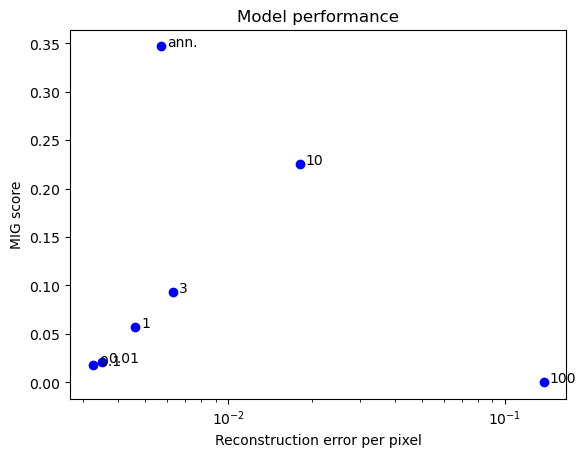

In [50]:
fig, ax = plt.subplots()
ax.scatter(x=reconstruction_scores, y=mig_scores, color='b')
ax.set_xscale('log')
ax.set_xlabel('Reconstruction error per pixel')
ax.set_ylabel('MIG score')
ax.set_title('Model performance')
for i, txt in enumerate(model_descriptions):
    ax.annotate(txt, (reconstruction_scores[i]*1.05, mig_scores[i]))

## Visualizing the effect of each latent dimension

Finally, we can visualize the effect of each of the 10 latent dimensions on generated images, for the model you think achieves the best trade-off between reconstruction and disentanglement.

To do so, we will pick a suitable image from the test dataset (choose an `index` below between `0` and `len(test_dataset)`; you can visualize the corresponding test image by running the cell below).

We will then compute the corresponding latent code `latent_z` (the mean of q(z|x)). Finally, we will modify one-by-one the latent dimensions of `latent_z`, going over the range of possible values for the selected dimension, while leaving all other dimensions unchanged. This allows us to see the modifications brought by each individual dimension on the output image.

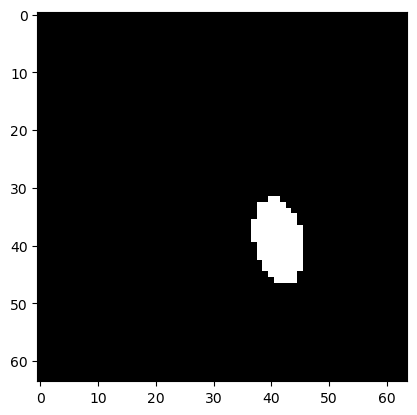

In [51]:
index = np.random.randint(0, len(test_dataset))
plt.imshow(test_dataset.imgs[index,:,:]*255, cmap='gray')

Specify the model (integer from 0 to 6 included) which you want to investigate and run the cell below.

The output of the cell recalls:
* the model you selected
* the latent code corresponding to the image indexed by your chosen `index` in the test dataset
* the normal reconstruction of this image by the selected model prior to changing any latent dimension

Picked model 𝛽=ann.

The latent code of the chosen image is:
tensor([ 0.7876,  1.1950,  0.8118,  0.7177,  1.0011, -0.3591, -1.3183,  0.9031,
        -0.2513,  3.1472])

The reconstruction by the model is:


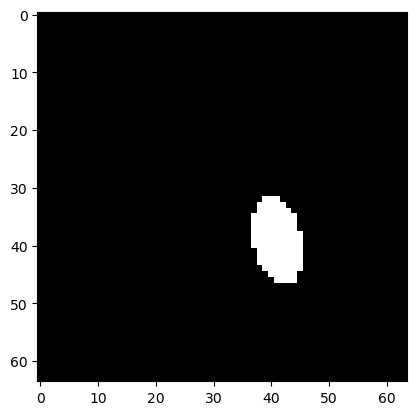

In [52]:
# models = [model_001, model_01, model_1, model_3, model_10, model_100, model_annealed]
mdl = -1
print("Picked model 𝛽={}".format(model_descriptions[mdl]))

print("\nThe latent code of the chosen image is:")
latent_z = test_stats_qzx[mdl, index, :, 0]
print(latent_z)

print("\nThe reconstruction by the model is:")
plt.imshow(test_reconstructions_image[mdl, index], cmap='gray')

Now, we visualize the effect of every latent dimension. Each latent dimension occupies a row in the figure below (there are 10 rows). Along row `i`, we vary the value of the latent dimension `i` between the min and max values observed in the test dataset, then decode the corresponding images and plot them.

In [53]:
min_code, _ = torch.min(test_stats_qzx[mdl,:,:,0], axis=0)
max_code, _ = torch.max(test_stats_qzx[mdl,:,:,0], axis=0)
range_code = torch.max(min_code.abs(), max_code.abs())

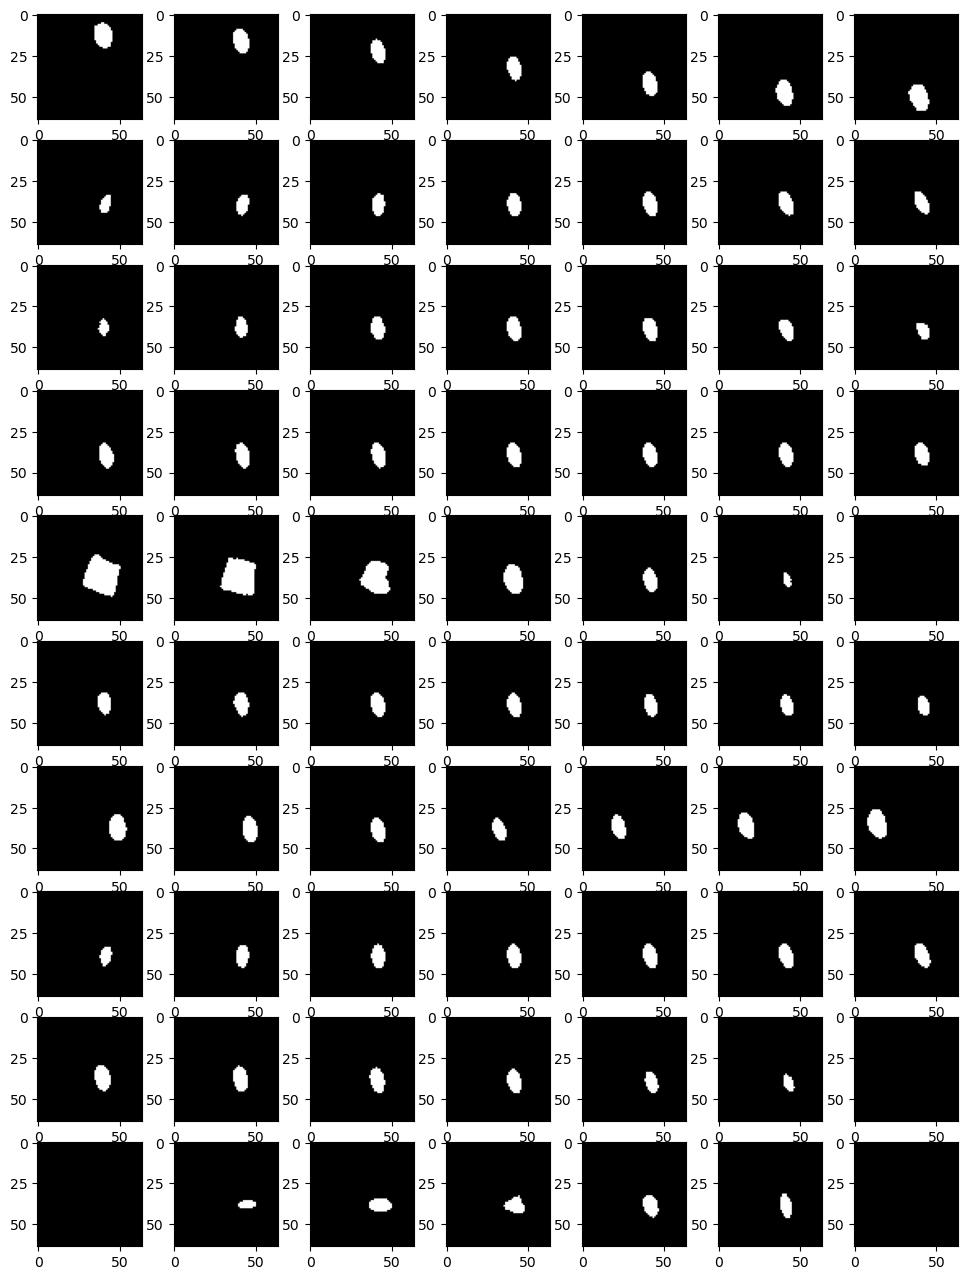

In [54]:
plt.figure(figsize=(12, 16))

for dim in range(0,10):
    for i in range(0,7):
        z = latent_z.clone().to(device)
        z[dim] = -range_code[dim] + 2*range_code[dim]*i/6
        z = z.unsqueeze(0)

        img = (models[mdl].generate_samples(samples_pz=z)['generations'].squeeze().detach().cpu().numpy() >= 0.5) * 255

        plt.subplot(10, 7, 7*dim+i+1)
        plt.imshow(img, cmap='gray')

**Questions:**
1. Can you associate some of the latent dimensions to some of the generative factors (among 'shape', 'scale', 'orientation', 'posX', 'posY')?
2. Do you think the factors are perfectly disentangled? Which ones are roughly disentangled and which ones are not?

**Answer**:

1. For this model:

- The first latent dimension seems to correspond to 'posY'.

- The second latent dimension seems to correspond to 'orientation'.

- The fifth latent dimension seems to correspond to both 'shape' and 'scale'.

- The seventh latent dimension seems to correspond to 'posX'.

2. For this specific model, 'posY', 'orientation', 'posX' seem rather well disentangled. However, 'shape' and 'scale' do not seem to be: when changing the fifth coordinate, we observe both a change in shape and in scale.

## Optional

For the selected model, you can quantify the amount of information encoded in each latent dimension by computing the average KL divergence between $q(z_i|x)$ and $\mathcal{N}(0,1)$, averaged over x.

(You can simply run the cells below to obtain these values.)

In [55]:
class KLMetric(object):
    def __init__(self):
      super().__init__()

    def __call__(self, stats_qzx):
        """
        Outputs: (D,) array
        Average (over x) KL divergence between q(z_i|x) and N(0,1) for every latent z_i
        """
        return kl_normal_loss(*stats_qzx.unbind(-1), batch_mean=True, component_sum=False)

In [56]:
kl_scores = torch.zeros(7, D)

for i,model in enumerate(models):
    kl_scores[i, :] = KLMetric()(test_stats_qzx[i])

In [57]:
print(kl_scores[mdl])

tensor([7.1661, 4.2612, 4.8483, 3.8890, 5.8823, 3.9919, 7.1851, 4.1252, 4.7838,
        5.7354])


This is not very informative, although there are two dimensions that slightly stand out with larger values. Which generative factors do they correspond to?

# References

Large parts of this notebook where adapted from Facebook's disentanglement lib: https://github.com/facebookresearch/disentangling-correlated-factors/tree/main (MIT, Apache-2.0 licenses).